In [32]:
import torch
from collections import defaultdict
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
from skimage import io, transform
import os
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, resnet34, ResNet34_Weights
from torchvision.datasets import EMNIST
import numpy as np
import time
from matplotlib import pyplot as plt
from google.colab import drive
from torch.utils.data import ConcatDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms.functional import to_tensor
import cv2
import copy
import PIL
from PIL import Image
import sklearn
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score

In [36]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [37]:
def train_model(model, dataloaders, criterion,  optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    acc_history = {"train":[], "val":[]}
    loss_history = {"train":[], "val":[]}
    f1_history = {"train":[], "val":[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_metric = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            running_metrics = {"precision":[], "recall":[], "f":[], "balanced":[]}
  
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()        
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':

                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs.float())
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    


                labels = labels.cpu()
                preds = preds.cpu()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                precision = precision_score(y_true = labels, y_pred = preds, average = "micro")
                recall = precision_score(y_true = labels, y_pred = preds, average = "micro")
                f_score = 2*precision*recall/(precision + recall)
                balanced_acc = balanced_accuracy_score(y_true = labels, y_pred = preds)*len(inputs)
                running_metrics["precision"].append(precision)
                running_metrics["recall"].append(recall)
                running_metrics["balanced"].append(balanced_acc)
                running_metrics["f"].append(f_score)
                


            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == "val":
              scheduler.step(epoch_loss)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_precision = np.median(np.asarray(running_metrics["precision"]))
            epoch_recall = np.median(np.asarray(running_metrics["recall"]))
            epoch_balanced = sum(running_metrics["balanced"]) / len(dataloaders[phase].dataset)
            epoch_f = np.median(np.asarray(running_metrics["f"]))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)
            f1_history[phase].append(epoch_f)
            

            print('{} Loss: {:.4f} Acc: {:.4f} prec: {:.4f}, reca: {:.4f}, bala: {:.4f}, f-sc: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_balanced, epoch_f))
            
            if phase == "val":
              if epoch_acc > best_metric:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_metric = epoch_acc


        print()
    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_metric))

    
    model.load_state_dict(best_model_wts)
    return (best_model_wts, best_metric) ,(acc_history, loss_history, f1_history)

In [4]:
def show_images(n):
  def inner(image_tensors):
      fig, axes = plt.subplots(nrows=5, ncols=n, figsize=(10, 4))
      for i, ax in enumerate(axes.flat):
        ax.imshow(image_tensors[i].numpy().transpose(1, 2, 0))
        ax.axis('off')
      plt.tight_layout()
      plt.show()
  return inner

In [5]:
def explore_dataset(dataset, n_images):
  random_indexes = np.random.randint(0, len(dataset)-1, 5*n_images)
  images = []
  show = show_images(n_images)
  for i in random_indexes:
    img, cls = dataset[i]
    images.append(img)
  show(images)
 


In [6]:
def find_initial_lr(dataloader, model_, criterion):
  model = copy.deepcopy(model_)
  lr_list = np.logspace(-5, stop = 0, num = len(dataloader))
  losses = []
  model.train()
  with torch.set_grad_enabled(True):
    for batch, (X, y) in enumerate(dataloader):
      X = X.cuda()
      y = y.cuda()
      outputs = model(X.float())
      loss = criterion(outputs, y)
      optimizer = torch.optim.AdamW(model.parameters(), lr=lr_list[batch])
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
  best_ind = np.asarray(losses).argmin()
  best_lr = lr_list[best_ind]
  plt.plot(lr_list, losses)
  plt.xlabel('Learning Rates')
  plt.xscale('log')
  plt.ylabel('Losses')
  plt.axvline(x=best_lr, color='r', linestyle='--')
  plt.savefig('/content/drive/MyDrive/best_initial_lr.png')
  return best_lr

In [42]:
def show_histories(histories):

  acc_hist, loss_hist, f1_hist = histories
  train_acc, test_acc = acc_hist["train"], acc_hist["val"]
  train_loss, test_loss = loss_hist["train"], loss_hist["val"]
  train_f1, test_f1 = f1_hist["train"], f1_hist["val"]

  fig, axs = plt.subplots(3, 1, figsize=(8, 12))
  

  axs[0].plot(train_acc, label='Train Accuracy')
  axs[0].plot(test_acc, label='Test Accuracy')
  axs[0].legend()
  axs[0].set_title('Accuracy History')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')


  axs[1].plot(train_loss, label='Train Loss')
  axs[1].plot(test_loss, label='Test Loss')
  axs[1].legend()
  axs[1].set_title('Loss History')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')


  axs[2].plot(train_f1, label='Train F1 Score')
  axs[2].plot(test_f1, label='Test F1 Score')
  axs[2].legend()
  axs[2].set_title('F1 Score History')
  axs[2].set_xlabel('Epoch')
  axs[2].set_ylabel('F1 Score')

  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/histories.png')

In [47]:
def test_model(test_loader, model):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        y_true.extend(targets.tolist())
        y_pred.extend(predicted.tolist())

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')

  print(f'Test accuracy: {accuracy:.4f}')
  print(f'Test F1 score: {f1:.4f}')

In [8]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean = 0, std=255.0, inplace=True)])
augment_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=(10, 10, 10, 10)) ,torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean = 0, std=255.0, inplace=True)])


In [9]:
RawTrain = EMNIST(split="balanced", download=True, root="./", train=True, transform=transform)
RawVal = EMNIST(split="balanced", download=True, root="./", train=False, transform=transform)
AugmentedTrain = EMNIST(split="balanced", download=True, root="./", train=True, transform=augment_transform)

100%|██████████| 561753746/561753746 [00:20<00:00, 27035289.25it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [10]:
lst = list(range(36, 47))
lst.append(18)
lst.append(24)
lst.append(26)
classes = torch.tensor(lst)

In [11]:
indices_train = (torch.tensor(RawTrain.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0].numpy()

In [12]:
indices_val= (torch.tensor(RawVal.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0].numpy()

In [13]:
RawTrain.data = np.delete(RawTrain.data, indices_train, axis=0)
RawTrain.classes = [RawTrain.classes[i] for i in range(len(RawTrain.classes)) if i not in lst]
RawTrain.targets = np.delete(RawTrain.targets, indices_train, axis=0)
RawTrain.targets[(19 <= RawTrain.targets) &  (RawTrain.targets <= 24) ] -= 1
RawTrain.targets[RawTrain.targets == 25 ] = 23
RawTrain.targets[RawTrain.targets >= 27 ] -= 3

In [14]:
train_size = int(0.95 * len(RawTrain))
test_size = len(RawTrain) - train_size

TrainData, TestDataset = random_split(RawTrain, [train_size, test_size])

In [24]:
train_indices = TrainData.indices

In [25]:
RawVal.data = np.delete(RawVal.data, indices_val, axis=0)
RawVal.classes = [RawVal.classes[i] for i in range(len(RawVal.classes)) if i not in lst]
RawVal.targets = np.delete(RawVal.targets, indices_val, axis=0)
RawVal.targets[(19 <= RawVal.targets) &  (RawVal.targets <= 24) ] -= 1
RawVal.targets[RawVal.targets == 25 ] = 23
RawVal.targets[RawVal.targets >= 27 ] -= 3

In [26]:
AugmentedTrain.data = np.delete(AugmentedTrain.data, indices_train, axis=0)
AugmentedTrain.classes = [AugmentedTrain.classes[i] for i in range(len(AugmentedTrain.classes)) if i not in lst]
AugmentedTrain.targets = np.delete(AugmentedTrain.targets, indices_train, axis=0)
AugmentedTrain.targets[(19 <= AugmentedTrain.targets) &  (AugmentedTrain.targets <= 24) ] -= 1
AugmentedTrain.targets[AugmentedTrain.targets == 25 ] = 23
AugmentedTrain.targets[AugmentedTrain.targets >= 27 ] -= 3

In [27]:
FinalAugmented = Subset(AugmentedTrain, train_indices)

In [29]:
TrainDataset = ConcatDataset([TrainData, FinalAugmented])

In [39]:
batch_size = 512
TrainLoader = DataLoader(TrainDataset, batch_size = batch_size, shuffle=True)
ValLoader = DataLoader(RawVal, batch_size = batch_size)
TestLoader = DataLoader(TestDataset, batch_size = batch_size)
DataLoaders = {"train":TrainLoader, "val":ValLoader}

In [ ]:
model = resnet34(pretrained = False)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.relu = nn.PReLU(64)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512,33)
    )
model.cuda()

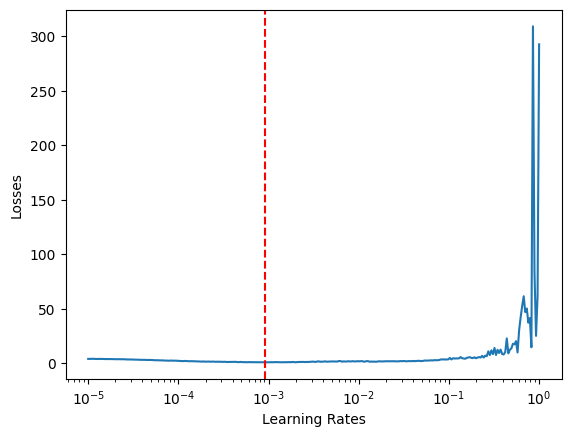

In [40]:
best_lr = find_initial_lr(TrainLoader, model, nn.CrossEntropyLoss())

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr)
weights, histories = train_model(model, DataLoaders, nn.CrossEntropyLoss(), optimizer)



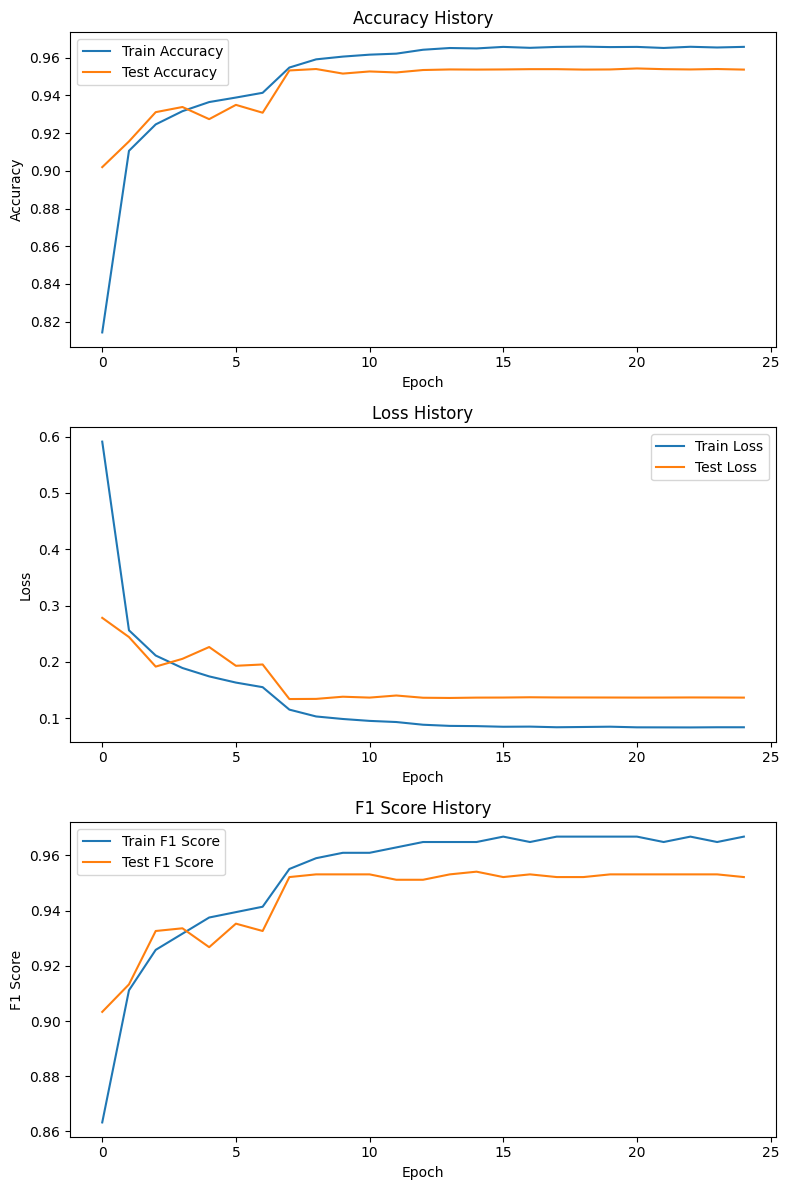

In [43]:
show_histories(histories)


In [45]:
model.load_state_dict(weights[0])

<All keys matched successfully>

In [48]:
test_model(TestLoader, model)

Test accuracy: 0.9515
Test F1 score: 0.9512
